In [47]:
from sklearn import metrics, ensemble
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [48]:
train = pd.read_csv('input/train.csv')
train = train.sample(frac=0.5)

songs = pd.read_csv('input/songs.csv')
train = pd.merge(train, songs, on='song_id', how='left')
del songs

members = pd.read_csv('input/members.csv')
train = pd.merge(train, members, on='msno', how='left')
del members

song_extra_info = pd.read_csv('input/song_extra_info.csv')
train = pd.merge(train, song_extra_info, on='song_id', how='left')
del song_extra_info

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 0 to 749999
Data columns (total 20 columns):
msno                      750000 non-null object
song_id                   750000 non-null object
source_system_tab         747683 non-null object
source_screen_name        715519 non-null object
source_type               748001 non-null object
target                    750000 non-null int64
song_length               749983 non-null float64
genre_ids                 739137 non-null object
artist_name               749983 non-null object
composer                  587854 non-null object
lyricist                  437784 non-null object
language                  749981 non-null float64
city                      750000 non-null int64
bd                        750000 non-null int64
gender                    453406 non-null object
registered_via            750000 non-null int64
registration_init_time    750000 non-null int64
expiration_date           750000 non-null int64
name       

In [65]:
train.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date
count,750000.0...,7.499830...,749981.0...,750000.0...,750000.0...,750000.0...,7.500000...,7.500000...
mean,0.666271,2.455737...,18.492366,7.576123,17.501940,6.775328,2.012775...,2.017149...
std,0.471545,6.115412...,21.175738,6.587155,21.305039,2.298958,2.983396...,3.889016...
min,0.000000,2.716000...,-1.000000,1.000000,-43.000000,3.000000,2.004033...,2.004102...
25%,0.000000,2.151960...,3.000000,1.000000,0.000000,4.000000,2.011071...,2.017091...
50%,1.000000,2.424160...,3.000000,5.000000,21.000000,7.000000,2.013102...,2.017093...
75%,1.000000,2.727180...,52.000000,13.000000,28.000000,9.000000,2.015101...,2.017101...
max,1.000000,7.371499...,59.000000,22.000000,1030.000000,13.000000,2.016121...,2.020102...


In [64]:
train.describe().to_html('dataframe_head.html')

In [66]:
train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date,name,isrc
0,ZQbQiWQg...,a1iJZwnK...,my library,Local pl...,local-pl...,0,238132.0,465,周杰倫 (Jay...,周杰倫,宋健彰,3.0,4,26,female,3,20160129,20170907,擱淺,TWK97040...
1,0tYvVpD0...,IIPVkO6E...,explore,Explore,online-p...,0,290168.0,458,安心亞 (Amb...,李榮浩,李榮浩,3.0,5,31,male,9,20100520,20171005,別再撐了,TWR03160...
2,un+M8wa2...,uWfF+7Tl...,my library,Local pl...,local-li...,1,254755.0,458,A-Lin,Eric周興哲,徐世珍/吳輝福,3.0,13,24,male,9,20150129,20170907,幸福太短 (Fl...,TWA47160...
3,FYdHbSh9...,EUm43qqC...,my library,Local pl...,local-pl...,1,168228.0,947,貴族精選,Digital ...,NaN,-1.0,1,0,NaN,7,20121220,20170915,時光流逝,NaN
4,pGB6bKP/...,Tlo3ydJu...,discover,NaN,song-bas...,0,360176.0,465,張雨生 (Tom...,NaN,NaN,3.0,1,0,NaN,7,20161111,20170910,河,TWB51970...


In [63]:
pd.set_option('display.max_colwidth',12)
train.head(5).to_html('headdata.html')

In [24]:
train.isnull().sum()

msno                           0
song_id                        0
source_system_tab           2386
source_screen_name         34346
source_type                 2056
target                         0
song_length                   10
genre_ids                  10800
artist_name                   10
composer                  162049
lyricist                  311502
language                      13
city                           0
bd                             0
gender                    296430
registered_via                 0
registration_init_time         0
expiration_date                0
name                          61
isrc                       59148
dtype: int64

In [25]:
for i in train.select_dtypes(include=['object']).columns:
    train[i][train[i].isnull()] = 'unknown'
train = train.fillna(value=0)

In [26]:
train.registration_init_time = pd.to_datetime(train.registration_init_time, format='%Y%m%d', errors='ignore')
train['registration_init_time_year'] = train['registration_init_time'].dt.year
train['registration_init_time_month'] = train['registration_init_time'].dt.month
train['registration_init_time_day'] = train['registration_init_time'].dt.day

train.expiration_date = pd.to_datetime(train.expiration_date,  format='%Y%m%d', errors='ignore')
train['expiration_date_year'] = train['expiration_date'].dt.year
train['expiration_date_month'] = train['expiration_date'].dt.month
train['expiration_date_day'] = train['expiration_date'].dt.day

del train['registration_init_time']
del train['expiration_date']
train.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,name,isrc,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,9//vyA8a6noe+FZNkyFOMsTBPb5K9TzfDZmxzyIlFpM=,JM8C0kiujGseUFvAB43PPmzEtJC0iflFIiRj8H1t6Ms=,my library,Local playlist more,local-playlist,1,282958.0,465,田馥甄 (Hebe),unknown,...,female,9,葉子,TWD951040910,2005,11,16,2017,9,30
1,ENLrrJ0F+atyZSSi7kZTbNjD83wSAGps8uhYjfVnKgo=,msy6vSQ15p6RVJfm/bSgcDwd3YSLp445Pdhzw6CEZRM=,my library,Local playlist more,local-playlist,1,194168.0,465,謝和弦 (R-chord),R-chord,...,female,7,女孩妳知道嗎 (You Know What| Girl?),TWA531579702,2011,5,21,2017,10,15
2,2TZvSesNpTmKloHuNgKGTqRjHitgoJjC9wHK+gqGaxs=,5GK7VfnddYFs21pMCU/lFqJXHtxW5Thx1clB5XBFLsM=,my library,Local playlist more,local-library,1,301662.0,465,張宇 (Phil Chang),Zhang Yu,...,male,9,趁早 (As Early As Possible),TWB430415002,2016,2,28,2017,7,17
3,xDcuTUZQhugCvOAmEhtpbtMreJ9oHmDMqREkC1iqZGU=,dRP9ON1AYPdVv1eOZ0ast5iQLXwl1blkwK5kj76M6TQ=,my library,Online playlist more,online-playlist,0,225593.0,465,萬芳,unknown,...,female,9,割愛,TWA459649602,2004,3,30,2017,11,14
4,KfcZSp62/7pK+eK++Wa6IzGFq6z5w/UqvBBmsHjoX3c=,6Bwu//FCFLxNnZYtZuwA3i7tPJCuLtoRNk56Q8IfGpE=,my library,Local playlist more,local-playlist,1,195709.0,2022,ONE OK ROCK,unknown,...,unknown,9,Take Me To The Top,USWB11507713,2015,5,21,2017,9,13
5,kXkMzhyacFrtSI922IBs0BcmNxKedV4+837lljPNTQA=,E/b+7QWv/HguM/u4uQXY1/2jeiFsxst6FRK2shsNHiU=,discover,Discover Feature,online-playlist,1,303438.0,458,李宗盛 (Jonathan Lee),李宗盛,...,female,9,愛的代價 (The Price of Love),TWK951600221,2013,12,3,2017,1,30
6,jYiR2IiN1N1+5S0rTAH0iEWC1QQtEmGJOvkwhvJRPOI=,Z209vommZHaIoJxBiaFA9hNJbNcTTTXSgSIS58J8r+w=,listen with,Others profile more,listen-with,1,241325.0,458,李玟 (CoCo Lee),Adia Chang,...,male,3,能不能,TWUM71300058,2012,5,13,2017,10,14
7,eOz0KfyF/jZ2hI84e54q1j0kd+TrF7mPe+ppQiz/Ues=,HWydiZOUWDm26gVTl5h7+Nj7L+SJ/VpNmL6yDSiiHW8=,my library,Local playlist more,local-playlist,1,276363.0,465,巨星系列,unknown,...,female,4,How Do I Live(我怎麼活),unknown,2016,6,23,2017,9,25
8,iaAlXCGCt1oNrW6MR7X2K4gsPWHbmdR0Pne9w6cpo6k=,x+wwBWqNXLShElFWaLs1ahI15dN4cl4ShC1/Wm4PsH4=,discover,Online playlist more,online-playlist,1,273345.0,465,李榮浩,李榮浩,...,male,4,李白,CNA231302848,2016,12,2,2017,6,10
9,0wIhAhyIWUfyuY8z8wfHd3TLBmaEqbx2fmfUweFLtNQ=,p9ht4E3BUSoGNSQDLqp+CNgZsyajg7FtGWjBSdWNRFQ=,my library,Local playlist more,local-library,0,249614.0,1609,Maxi Kingdom,unknown,...,female,9,REWIND THE MUSIC-DJ JERRY (羅百吉),unknown,2014,7,18,2017,1,17


In [27]:
categorical_feature = train.dtypes==object
categorical_cols = train.columns[categorical_feature].tolist()
categorical_cols

['msno',
 'song_id',
 'source_system_tab',
 'source_screen_name',
 'source_type',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'gender',
 'name',
 'isrc']

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train[categorical_cols] = train[categorical_cols].apply(lambda col: le.fit_transform(col))
train[categorical_cols].head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,genre_ids,artist_name,composer,lyricist,gender,name,isrc
0,3102,33345,3,7,4,206,13394,22452,8736,0,67701,49809
1,4635,79270,3,7,4,206,13931,16882,6537,0,52370,43624
2,1252,11405,3,7,3,206,12390,22167,7211,1,69074,45978
3,17799,64609,3,10,5,206,13728,22452,8736,0,49079,40371
4,6453,12801,3,7,4,106,7405,22452,8736,2,35474,75466
5,14058,25042,0,3,5,203,12771,24492,10937,0,56903,53709
6,13765,57720,2,11,2,203,12813,564,8736,1,66973,56550
7,12325,30501,3,7,4,206,12312,22452,8736,0,15829,76510
8,13500,95036,0,10,5,206,12796,24529,11007,1,61158,1508
9,819,82971,3,7,3,71,6636,22452,8736,0,29341,76510


In [29]:
#train.to_csv('train_data.csv')
train.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,name,isrc,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,3102,33345,3,7,4,1,282958.0,206,13394,22452,...,0,9,67701,49809,2005,11,16,2017,9,30
1,4635,79270,3,7,4,1,194168.0,206,13931,16882,...,0,7,52370,43624,2011,5,21,2017,10,15
2,1252,11405,3,7,3,1,301662.0,206,12390,22167,...,1,9,69074,45978,2016,2,28,2017,7,17
3,17799,64609,3,10,5,0,225593.0,206,13728,22452,...,0,9,49079,40371,2004,3,30,2017,11,14
4,6453,12801,3,7,4,1,195709.0,106,7405,22452,...,2,9,35474,75466,2015,5,21,2017,9,13
5,14058,25042,0,3,5,1,303438.0,203,12771,24492,...,0,9,56903,53709,2013,12,3,2017,1,30
6,13765,57720,2,11,2,1,241325.0,203,12813,564,...,1,3,66973,56550,2012,5,13,2017,10,14
7,12325,30501,3,7,4,1,276363.0,206,12312,22452,...,0,4,15829,76510,2016,6,23,2017,9,25
8,13500,95036,0,10,5,1,273345.0,206,12796,24529,...,1,4,61158,1508,2016,12,2,2017,6,10
9,819,82971,3,7,3,0,249614.0,71,6636,22452,...,0,9,29341,76510,2014,7,18,2017,1,17


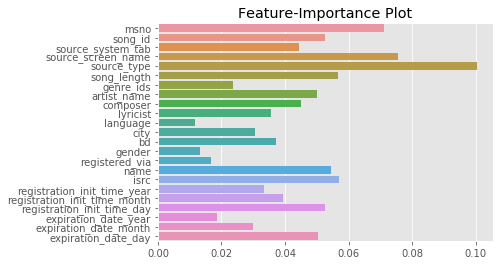

In [13]:
X = train[train.columns[train.columns != 'target']]
y = train.target

model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=25)
model.fit(X, y)

features = train.columns[train.columns != 'target']
importance_values = model.feature_importances_

sns.barplot(x = importance_values, y =features )
plt.title('Feature-Importance Plot')
plt.show()

In [14]:
imporant_feat = pd.concat([(features.to_series().reset_index(drop=True)), pd.DataFrame(importance_values)], axis=1)
imporant_feat.columns = ['features', 'importance_values']
imporant_feat[importance_values>0.05]

,features,importance_values
0,msno,0.071027
1,song_id,0.052548
3,source_screen_name,0.075662
4,source_type,0.100382
5,song_length,0.056540
7,artist_name,0.050155
15,name,0.054579
16,isrc,0.056940
19,registration_init_time_day,0.052613
22,expiration_date_day,0.050430


Text(0.5, 1, 'Relationship Between Important Features')

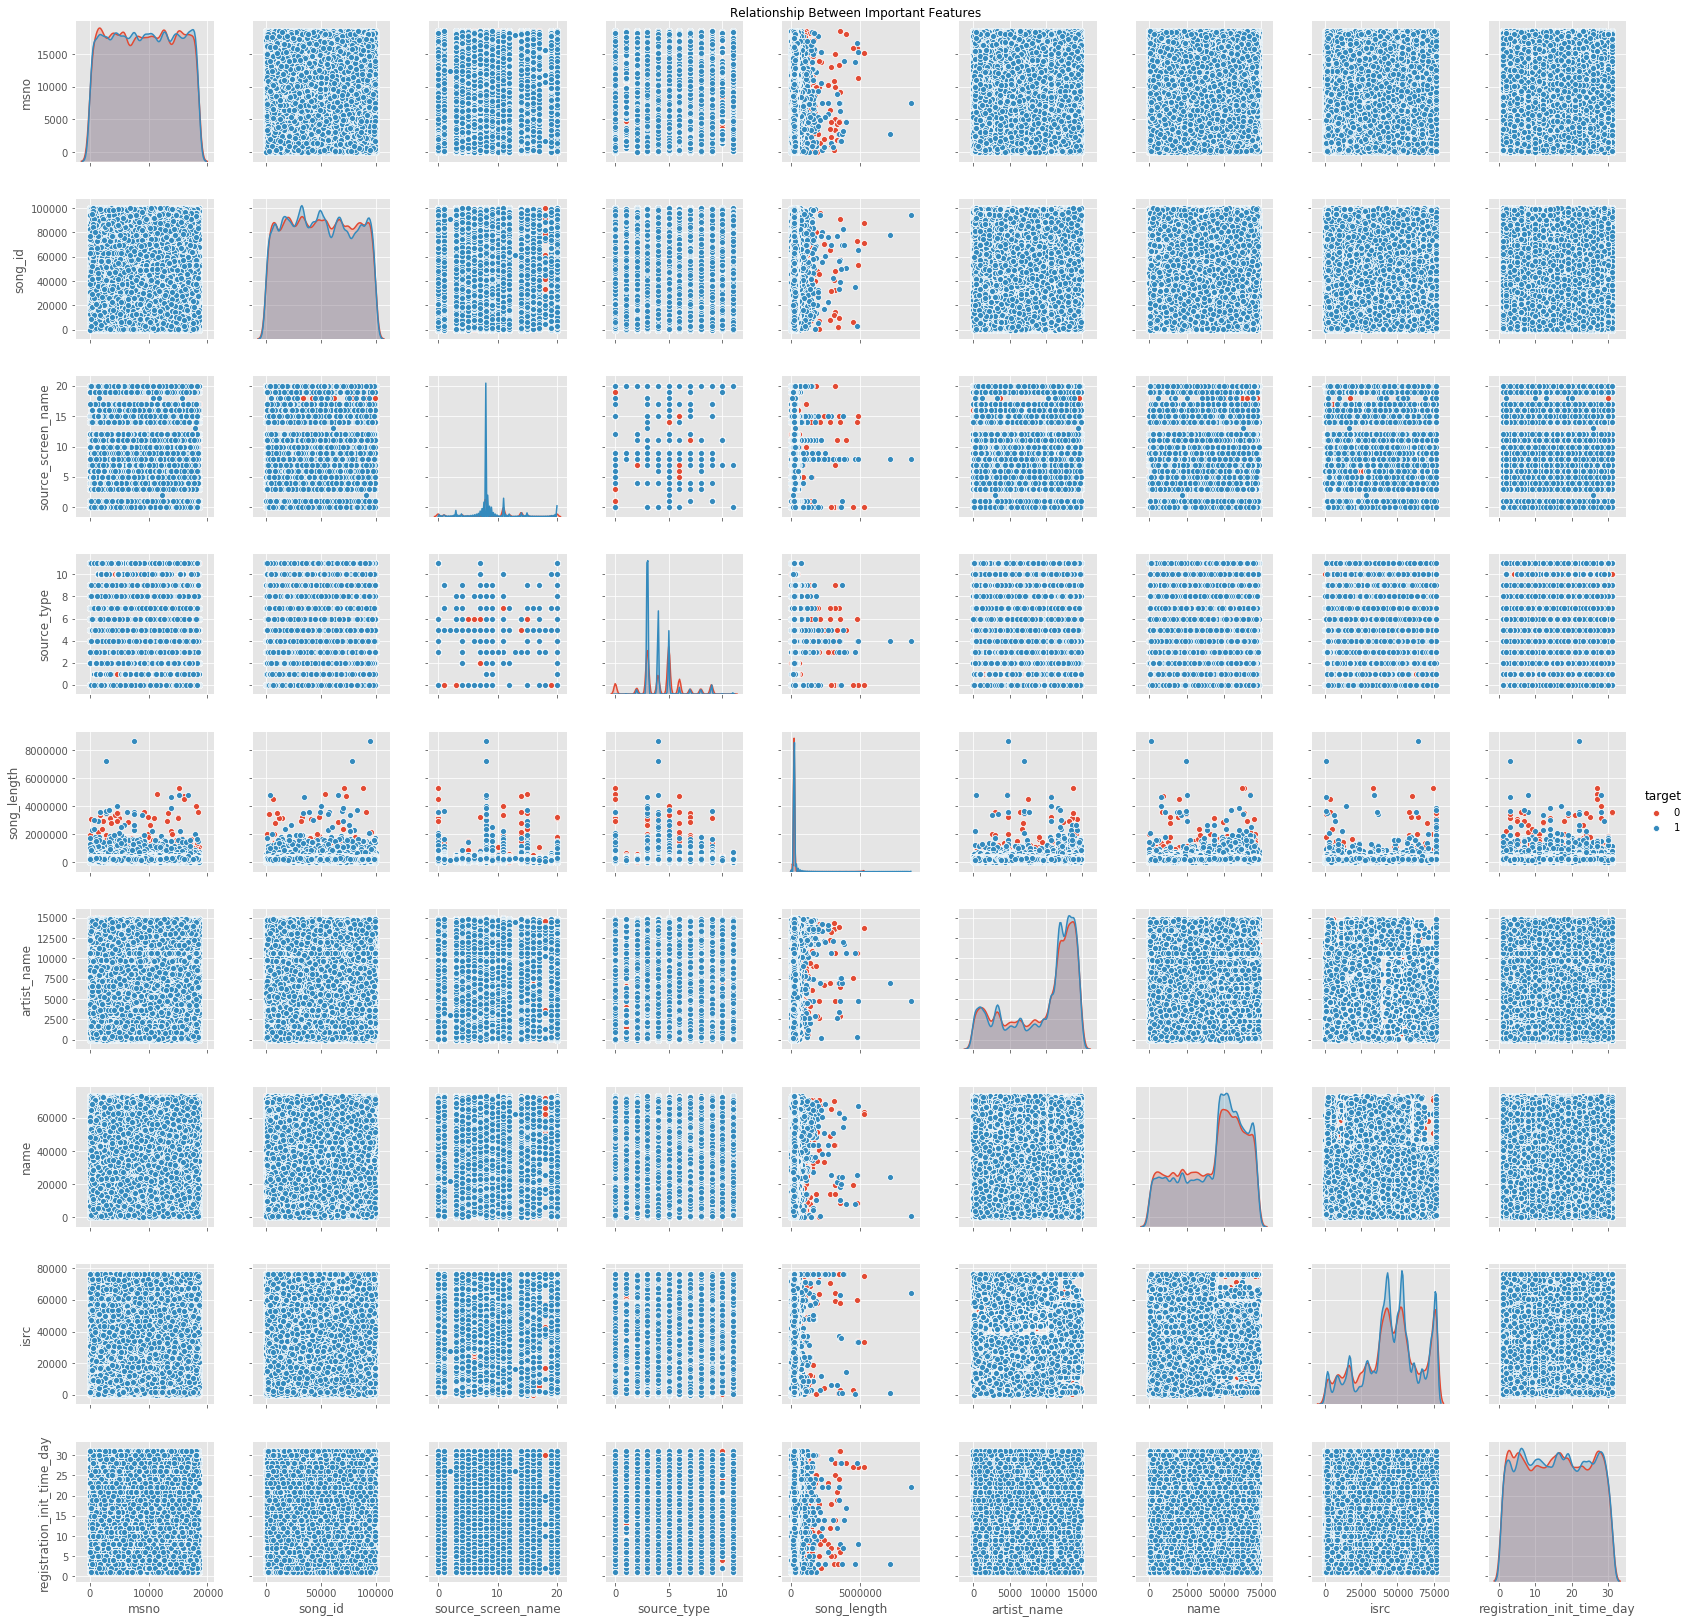

In [15]:
# To have a look at relationship between the important Features >0.05
imporant_features = ['msno', 'song_id', 'source_screen_name','source_type', 'song_length','artist_name','name', 'isrc', 'registration_init_time_day']
pair_plot_imp = sns.pairplot(train, vars=imporant_features, hue='target')
pair_plot_imp.fig.suptitle("Relationship Between Important Features", y=1) 

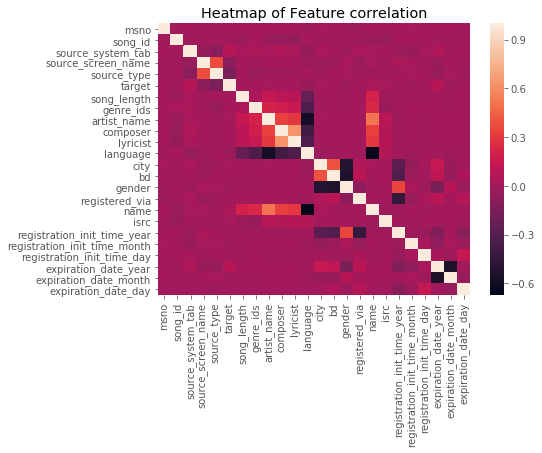

In [16]:
# Heatmap of the Feature correlation
plt.figure(figsize=[7,5])
sns.heatmap(train.corr())
plt.title('Heatmap of Feature correlation')
plt.show()

In [30]:
train.columns
#train.count(axis='columns')

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'lyricist', 'language', 'city', 'bd', 'gender',
       'registered_via', 'name', 'isrc', 'registration_init_time_year',
       'registration_init_time_month', 'registration_init_time_day',
       'expiration_date_year', 'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [31]:
target = train.pop('target')

In [32]:
train_data, test_data, train_labels, test_labels = train_test_split(train, target, test_size = 0.3)

In [33]:
# To be used as BaseLine
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

lrmodel = LinearRegression()  
lrmodel.fit(train_data, train_labels)
test_pred = lrmodel.predict(test_data)
test_pred = np.where(test_pred > 0.49, 1, 0)

accuracy_score(test_labels, test_pred)

0.6695111111111111

In [20]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

for clf in classifiers:
    print("="*30)
    name = clf.__class__.__name__
    print(name)
    
    clf.fit(train_data, train_labels)    
    test_predictions = clf.predict(test_data)
    print(accuracy_score(test_labels, test_predictions))
    
print("="*30)

KNeighborsClassifier
0.6174977777777778
DecisionTreeClassifier
0.6889688888888889
RandomForestClassifier
0.7469155555555556
AdaBoostClassifier
0.7149555555555556
GradientBoostingClassifier
0.7227822222222222
GaussianNB
0.6654755555555556
LinearDiscriminantAnalysis
0.6736977777777777
QuadraticDiscriminantAnalysis
0.6808177777777777


In [21]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 42

first_classifier = GradientBoostingClassifier()
second_classifier = RandomForestClassifier(random_state=RANDOM_SEED)

logist_regression = LogisticRegression()

classifier_stack = StackingCVClassifier(classifiers=[first_classifier, second_classifier], meta_classifier=logist_regression, random_state=RANDOM_SEED)

print('Stacking Classifiers')

for clf, label in zip([first_classifier, second_classifier, classifier_stack], 
                      ['GradientBoostingClassifier', 'RandomForestClassifier', 'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, train_data, train_labels,cv=3, scoring='accuracy')
    print("Accuracy: %0.2f [%s]" % (scores.mean(), label))

Stacking Classifiers
Accuracy: 0.72 [GradientBoostingClassifier]
Accuracy: 0.74 [RandomForestClassifier]
Accuracy: 0.73 [StackingClassifier]


In [22]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

d_train = lgb.Dataset(train_data, label= train_labels)
params = {}
params['learning_rate']= 0.1
params['max_depth']=10
clf= lgb.train(params, d_train)
y_pred = clf.predict(test_data)
y_pred = np.where(y_pred > 0.49, 1, 0)

print(accuracy_score(y_pred, test_labels))

0.7370488888888889


In [23]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=100)
model.fit(train_data, train_labels)
predict_labels = model.predict(test_data)
print(metrics.accuracy_score(test_labels, predict_labels))

0.7647022222222222


Best: 0.727335 accuracy {'learning_rate': 0.3}
0.697745 (0.000511) with: {'learning_rate': 0.0001}
0.698490 (0.000935) with: {'learning_rate': 0.001}
0.708467 (0.000938) with: {'learning_rate': 0.01}
0.720539 (0.001524) with: {'learning_rate': 0.1}
0.724629 (0.001386) with: {'learning_rate': 0.2}
0.727335 (0.001579) with: {'learning_rate': 0.3}


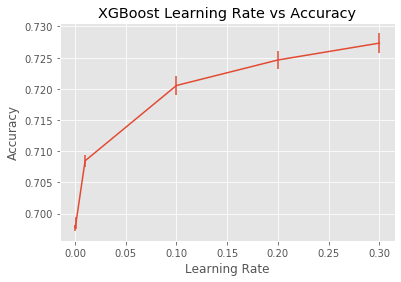

In [24]:
# Tuning the Learning Rate for Accuracy
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

model = xgb.XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)

grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1)
grid_result = grid_search.fit(train_data, train_labels)

print("Best: %f accuracy %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost Learning Rate vs Accuracy")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

Best: 0.728194 accuracy {'n_estimators': 350}
0.715415 (0.001089) with: {'n_estimators': 50}
0.720539 (0.001524) with: {'n_estimators': 100}
0.722787 (0.001432) with: {'n_estimators': 150}
0.724566 (0.001215) with: {'n_estimators': 200}
0.726162 (0.001379) with: {'n_estimators': 250}
0.727101 (0.001363) with: {'n_estimators': 300}
0.728194 (0.001168) with: {'n_estimators': 350}


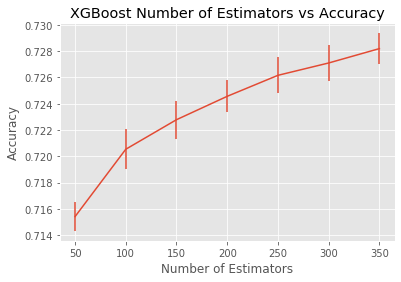

In [25]:
# Tuning the Number of Decision Trees for Accuracy
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

model = xgb.XGBClassifier()
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)

grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1)
grid_result = grid_search.fit(train_data, train_labels)

print("Best: %f accuracy %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost Number of Estimators vs Accuracy")
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()

Best: 0.751524 accuracy {'max_depth': 9}
0.702236 (0.000403) with: {'max_depth': 1}
0.720539 (0.001524) with: {'max_depth': 3}
0.730425 (0.001129) with: {'max_depth': 5}
0.741688 (0.001292) with: {'max_depth': 7}
0.751524 (0.001729) with: {'max_depth': 9}


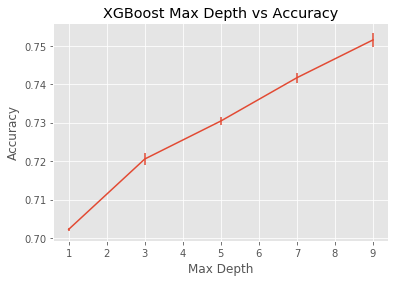

In [26]:
# Tuning the Size of Decision Trees for Accuracy
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

model = xgb.XGBClassifier()
max_depth = range(12, 22, 2)
param_grid = dict(max_depth=max_depth)

grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1)
grid_result = grid_search.fit(train_data, train_labels)

print("Best: %f accuracy %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost Max Depth vs Accuracy")
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

5 8.697835922241211
6 8.137639284133911
7 7.420692443847656
8 6.884056091308594


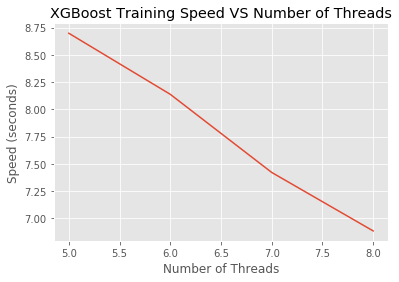

In [27]:
# Plotting training time with Number of threads
import matplotlib.pyplot as plt
import time

results = []
num_jobs = [5, 6, 7,8]
for n in num_jobs:
    start = time.time()
    model = xgb.XGBClassifier(n_jobs=n)
    model.fit(train_data, train_labels)
    elapsed = time.time() - start
    print(n, elapsed)
    results.append(elapsed)

plt.plot(num_jobs, results)
plt.ylabel('Speed (seconds)')
plt.xlabel('Number of Threads')
plt.title('XGBoost Training Speed VS Number of Threads')
plt.show()

In [28]:
model = xgb.XGBClassifier(max_depth=20, learning_rate=0.3, n_estimators=300, n_jobs=8)
model.fit(train_data, train_labels)
predict_labels = model.predict(test_data)
print(metrics.accuracy_score(test_labels, predict_labels))

0.7819733333333333


In [29]:
#model = xgb.XGBClassifier(max_depth=20, learning_rate=0.3, min_child_weight=3, n_estimators=100, scale_pos_weight=1, seed=1)
#model.fit(train_data, train_labels, eval_metric='auc', eval_set=[(test_data, test_labels)], early_stopping_rounds=100)

In [30]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=300)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [31]:
predict_labels = model.predict(test_data)

print(metrics.classification_report(test_labels, predict_labels))
print(metrics.accuracy_score(test_labels, predict_labels))
print(metrics.roc_auc_score(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64     74929
           1       0.81      0.90      0.85    150071

    accuracy                           0.79    225000
   macro avg       0.77      0.73      0.74    225000
weighted avg       0.78      0.79      0.78    225000

0.7872
0.7319791703101244


## Ignore the below implementation

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
model = Sequential()
model.add(Dense(64, input_dim=23, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Using TensorFlow backend.
W0927 02:28:26.555955 140560318105408 deprecation_wrapper.py:119] From /home/deeplearning/anaconda3/envs/udacityml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 02:28:26.570237 140560318105408 deprecation_wrapper.py:119] From /home/deeplearning/anaconda3/envs/udacityml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 02:28:26.574177 140560318105408 deprecation_wrapper.py:119] From /home/deeplearning/anaconda3/envs/udacityml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 02:28:26.584730 140560318105408 deprecation_wrapper.py:119] From /home/deeplearning/anaconda3/envs/udacityml/lib/python3.7/site-packages/keras/backend/te

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1536      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
__________

In [34]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

W0927 02:28:26.676219 140560318105408 deprecation_wrapper.py:119] From /home/deeplearning/anaconda3/envs/udacityml/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 02:28:26.691033 140560318105408 deprecation_wrapper.py:119] From /home/deeplearning/anaconda3/envs/udacityml/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0927 02:28:26.695823 140560318105408 deprecation.py:323] From /home/deeplearning/anaconda3/envs/udacityml/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [35]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)
print(train_data.size)
train_data.shape

12075000


(525000, 23)

In [36]:
model.fit(train_data, train_labels, epochs=25, batch_size=1000, callbacks=[early_stopping_monitor])

Epoch 1/25
525000/525000 [==============================] - 4s 7us/step - loss: 5.3449 - acc: 0.6647
Epoch 2/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 3/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 4/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 5/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 6/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 7/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 8/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 9/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - acc: 0.6647
Epoch 10/25
525000/525000 [==============================] - 3s 6us/step - loss: 5.3449 - a

In [37]:
accuracy = model.evaluate(test_data, test_labels)

225000/225000 [==============================] - 2s 10us/step 


In [38]:
#print('Accuracy: %.2f' % (accuracy*100))
print(model.metrics_names)
accuracy

['loss', 'acc']


[5.309097780710856, 0.6669822222222223]